# Lab 2

This lab is for practicing Python’s *generators* and the design of *streaming* algorithms in general. We’re going to use two Citibike's data sets: **citibike.csv** and **citibike_docking_events.csv**. Both are available on Blackboard's *Data Sets* section.

In [6]:
import csv
import datetime
import dateutil
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes("muted")

## Task 1

Plotting the number of trips taken by hour of the day in '''citibike.csv'''. In this task, we would write a generator to convert each line of an input citibike CSV into a stream of “hour of the day” values.

In [1]:
def citibike2hod(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            starttime = dateutil.parser.parse(row['starttime'])
            yield(starttime.hour)

In [8]:
count = {}
for hod in citibike2hod('citibike.csv'):
    count[hod] = count.get(hod,0)+1

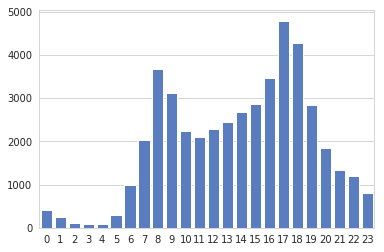

In [9]:
ax = sns.barplot(x=list(count.keys()),
                 y=list(count.values()),
                 color='b')

## Task 2

Our task is to write a generator to extract the first ride of the day from a Citibike data stream. The data stream is sorted based on starting times. The first ride of the day is interpreted as the ride with the earliest starting time of a day.

We are given a template with the sample generator **firstRide**. The generator currently takes in **csv.DictReader** generator and output its first element. We need to adjust this generator to output the first ride of the day for the entire stream as specified above. The output of the generator must be in the same format as csv.DictReader. We can think of this generator as a filter only passing certain records through.

In [12]:
### NOTE: We need to change the body of the generator firstRide
### in order to output trip record that appeared first in each day
### using the same dict format as csv.DictReader.

def firstRide(reader):
    lastDay = None
    for rider in reader:
        day = datetime.datetime.strptime(rider['starttime'], '%Y-%m-%d %H:%M:%S+%f')
        if lastDay!=day.date():
            lastDay = day.date()
            yield(rider)

### NOTE: We SHOULD NOT modify the code below. If we
### write our firstRide generator above correctly, the
### code below will output the correct information

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    for row in firstRide(reader):
        print(','.join(map(row.get, reader.fieldnames)))

1,,801,2015-02-01 00:00:00+00,2015-02-01 00:14:00+00,521,8 Ave & W 31 St,40.75044999,-73.99481051,423,W 54 St & 9 Ave,40.76584941,-73.98690506,17131,Subscriber,1978,2
6442,,199,2015-02-02 00:02:00+00,2015-02-02 00:05:00+00,442,W 27 St & 7 Ave,40.746647,-73.993915,489,10 Ave & W 28 St,40.75066386,-74.00176802,20684,Subscriber,1992,1
7901,,704,2015-02-03 00:00:00+00,2015-02-03 00:12:00+00,387,Centre St & Chambers St,40.71273266,-74.0046073,2008,Little West St & 1 Pl,40.70569254,-74.01677685,20328,Subscriber,1982,1
12655,,146,2015-02-04 00:00:00+00,2015-02-04 00:02:00+00,237,E 11 St & 2 Ave,40.73047309,-73.98672378,438,St Marks Pl & 1 Ave,40.72779126,-73.98564945,15253,Subscriber,1969,1
21628,,1034,2015-02-05 00:00:00+00,2015-02-05 00:17:00+00,497,E 17 St & Broadway,40.73704984,-73.99009296,461,E 20 St & 2 Ave,40.73587678,-73.98205027,20290,Subscriber,1971,1
30836,,212,2015-02-06 00:01:00+00,2015-02-06 00:05:00+00,491,E 24 St & Park Ave S,40.74096374,-73.98602213,472,E 32 St & Park Ave,40

## Task 3

Our task is to **compute the maximum number of active "citibikers"** that were using the Citibike service at any point in time. This the same as computing the maximum number of citibikes that were checked out at a particular time. The input data set is **citibike_docking_events.csv**, which logged all docking and undocking events at all Citibike stations. The description of the fields in this file is as follows:

|Column name|Description|
|--|--|
|time |The timestamp of the event. All events are sorted increasingly by their timestamps. |
|bikeid |The unique ID of the bike involved in this event. |
|station_id |The station ID, where the event happened. |
|event |A string of either *"dock"* or *"undock"* for describing the drop-off or pick-up event, respectively. |

For example, let's assume that on *Feb-01-2015*, there was a user that picked a bike at the station ID *521* at midnight and dropped it at the station ID *423* at 14 minutes past midnight. If the bike that this customer used has the ID of *17131*, then we should see two events being logged in this data set as:

<pre>
...
2015-02-01 00:00:00+00,17131,521,undock
...
2015-02-01 00:14:00+00,17131,423,dock
...
</pre>

We are given the above data set in a streaming fashion (reading in row by row), and must design a streaming algorithm that uses the least possible additional memory to compute the maximum number of active users of the Citibike service. Please modify the code snippet below to complete this task. The code should only output a single number, which is the number of active users. It is allowable to add additional initialization codes outside of the for loop as needed.

In [14]:
def csvRows(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            yield(row)

maxActiveUsers = 0
activeUsers = 0
for row in csvRows('citibike_docking_events.csv'):
    if row['event']=='undock':
        activeUsers += 1
    if row['event']=='dock':
        activeUsers -= 1
    maxActiveUsers = max(maxActiveUsers, activeUsers)
    
print(maxActiveUsers)

250


## Task 4

The objective of this task is identical to Task 3's but we are asked to use the **cibibike.csv** data set instead of the docking events. The main difference (and challenge) is that both pick-up and drop-off event for each trip is now presented as a single record, thus, the drop-off events are not sorted by their timestamps. We are again asked to do this in a streaming fashion that needs to minimize the amount of memory usage. Please modify the code below accordingly, and also with a brief explaination of the solution.

In [16]:
##Maximum count problem
def csvRows(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            yield(row)

maxActiveUsers = 0
maxTime = None
notYetReturns = []
for row in csvRows('citibike.csv'):
    starttime = row['starttime']
    stoptime  = row['stoptime']
    
#     newNotYetReturns = []
#     for st in notYetReturns:
#         if st>starttime:
#             newNotYetReturns.append(st)
#     notYetReturns = newNotYetReturns
    
    notYetReturns = filter(lambda x: x>starttime, notYetReturns)
    notYetReturns = list(notYetReturns) + [stoptime]
    if maxActiveUsers<len(notYetReturns):
        maxActiveUsers,maxTime = len(notYetReturns),starttime

print(maxActiveUsers)
print(maxTime)

250
2015-02-05 08:55:00+00
